In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.mixture import GaussianMixture
from sklearn.svm import  SVC
import math
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns

%matplotlib inline

### Leer dataset

In [2]:
#PATHDATA = '../data/audiosData.csv'
PATHDATA_2 = '../data/audiosData_2.csv'
df = pd.read_csv(PATHDATA_2, header = None)
data = df.values #Convertimos en un  numpy array

In [3]:
X = data[:,0:-2]
Y = data[:,-1]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-2:-1]


Tamaño dataSet (15000, 162)




### Número de clases

In [4]:
n_classes=len(np.unique(Y))
print('Número de clases:', n_classes)

Número de clases: 5


### Número de hablantes

In [5]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 1914


## Dividir el dataset (train/test) 0.8/0.2

In [6]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
gss.get_n_splits()
for train_index, test_index in gss.split(X, Y, groups=groups):
    X_train_original, X_test__original = X[train_index], X[test_index]
    #print(X_train, X_test)
    Y_train__original, Y_test__original = Y[train_index], Y[test_index]
    #print(y_train, y_test)
    groups_original = groups[train_index]

In [7]:
groups_original.shape

(11855, 1)

In [8]:
X_train_original.shape

(11855, 162)

In [9]:
Y_train__original.shape

(11855, 1)

In [10]:
def build_model(model, parameters, folds, train_size, X,Y,groups_original):
  acc_scorer = make_scorer(accuracy_score)
  recalls = make_scorer(recall_score,average='micro')##buscar por que micro
  precision = make_scorer(precision_score,average='micro')
  f1 = make_scorer(f1_score,average='micro')
  scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
  gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
  model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups_original))
  model.fit(X,Y)
  return model 

# GaussianMixture (GMM) 

In [11]:
FOLDS = 10
TRAIN_SIZE = 0.8

## 1. Mejor modelo

Usamos X_train_original y Y_train__original para seleccionar la mejor combinación de parametros y posteriormente validar dichos resultados con el conjunto X_test__original y Y_test__original.

<b>Nota:</b> el conjunto X_train_original se divide en dos conjuntos train y dev a una proporción de 80 a 20.


In [12]:
parameters ={'n_components' : [2,3,4,5,6,7,8,9,10],'covariance_type': ['tied','full','spherical','diag']}
GMM =GaussianMixture()#Configurar el modelo
model_trained_gmm = build_model(GMM, parameters, FOLDS, TRAIN_SIZE, X_train_original,Y_train__original,groups_original)
best_params_gmm = model_trained_gmm.cv_results_['params'][model_trained_gmm.best_index_]
print(best_params_gmm)

{'covariance_type': 'full', 'n_components': 5}


In [13]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_gmm = []
for p in params_acurracy:
    parameter_acurracy =model_trained_gmm.cv_results_[p][model_trained_gmm.best_index_]
    best_acurracy_gmm.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_gmm)
best_acurracy_gmm

Resultados mejor modelo:  {'covariance_type': 'full', 'n_components': 5}


[{'mean_train_Accuracy': 0.1997739687684343},
 {'mean_test_Accuracy': 0.20478423145856564},
 {'std_train_Accuracy': 0.02182231085313753},
 {'std_test_Accuracy': 0.024472625132633714}]

## 2. Evalución mejor modelo con el conjunto de test

In [14]:
clases = ['yes','no','right','five','nine']
def Metrics(model,X_test,Y_test):

  y_predicted = model.predict(X_test)
  print('Accuracy: ', accuracy_score(Y_test, y_predicted), '\n')
  report = classification_report(Y_test, y_predicted)
  print("\nclassification report :\n",report )
 
  # Matriz de confusión
  cm = confusion_matrix(Y_test, y_predicted)
  # Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)
  
  #sns.heatmap(cm,annot=True,fmt = "d",linecolor="k",linewidths=3)
  #plt.title("Matriz de confusión",fontsize=20)
   
    
  return report

<b>Nota:</b> Usamos los conjuntos X_test__original y Y_test__original para evaluar el comportamiento del mejor modelo con datos

Accuracy:  0.18982511923688394 


classification report :
               precision    recall  f1-score   support

         0.0       0.14      0.13      0.13       646
         1.0       0.22      0.25      0.23       623
         2.0       0.17      0.15      0.16       600
         3.0       0.19      0.17      0.18       626
         4.0       0.22      0.26      0.24       650

    accuracy                           0.19      3145
   macro avg       0.19      0.19      0.19      3145
weighted avg       0.19      0.19      0.19      3145



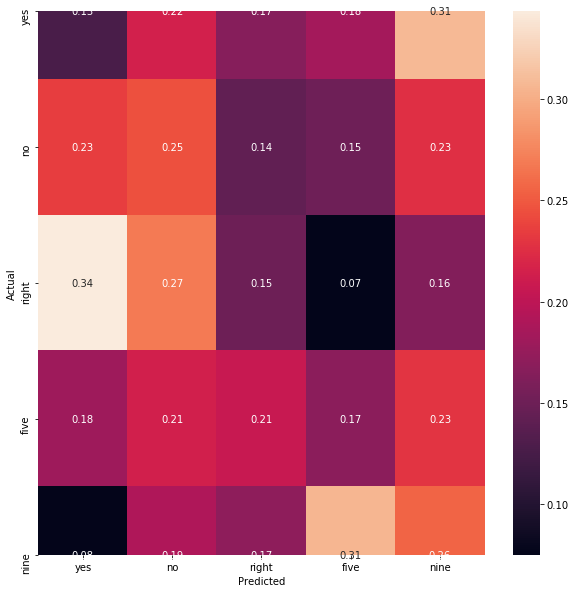

In [15]:
gmm_best_estimator = model_trained_gmm.best_estimator_
metrics = Metrics(gmm_best_estimator,X_test__original,Y_test__original)

## 3. Curva de aprendizaje con el mejor modelo

<b>Nota:</b> Esta curva se realiza con todo el conjunto de datos es decir X y Y

In [16]:
def learning_curve(model,best_parameters,folds, X,Y,groups=groups, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy'):
    """
    Parameters
    ----------
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    std_train= []
    std_val=[]

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(.1,.9,5).tolist()
    # for each one of those training set sizes
    
    for i in training_set_sizes:  
        model_trained = build_model(model, best_parameters, folds, i, X,Y,groups)                
        EfficiencyVal= model_trained.cv_results_['mean_test_Accuracy'][model_trained.best_index_]
        EfficiencyTrain=model_trained.cv_results_['mean_train_Accuracy'][model_trained.best_index_]
        stdTrain=model_trained.cv_results_['std_train_Accuracy'][model_trained.best_index_]
        stdVal=model_trained.cv_results_['std_test_Accuracy'][model_trained.best_index_]

        # store the scores in their respective lists
        train_score.append(EfficiencyTrain)
        val_score.append(EfficiencyVal)
        std_train.append(stdTrain)
        std_val.append(stdVal)

    train_score =np.array(train_score)
    val_score =np.array(val_score)
    std_train =np.array(std_train)
    std_val =np.array(std_val)


    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')
    
    ax.fill_between(training_set_sizes,train_score+std_train,train_score-std_train,facecolor='gold',alpha=0.5)
    ax.fill_between(training_set_sizes,val_score+std_val,val_score-std_val,facecolor='steelblue',alpha=0.5)

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['Train set', 'Test set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)
    data = {'Train_Size':training_set_sizes, 'mean_train_Accuracy':train_score,'mean_test_Accuracy':val_score,'std_train_Accuracy':std_train,'std_test_Accuracy':std_val}
    df_split_params = pd.DataFrame(data)
    return df_split_params

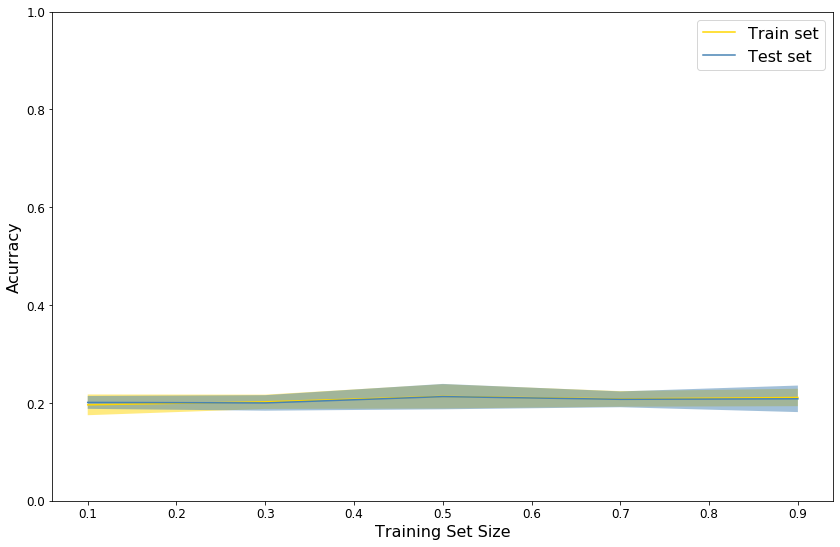

In [17]:
best_params_GMM = {'covariance_type': ['full'], 'n_components': [5]}
df_split_params =learning_curve(model=GMM,best_parameters=best_params_GMM,folds=10, X=X,Y=Y,groups=groups)

In [18]:
df_split_params

,Train_Size,mean_train_Accuracy,mean_test_Accuracy,std_train_Accuracy,std_test_Accuracy
0,0.1,0.196129,0.201104,0.021201,0.013151
1,0.3,0.202369,0.200057,0.014589,0.015842
2,0.5,0.213429,0.212973,0.024817,0.025955
3,0.7,0.208226,0.207430,0.015883,0.016160
4,0.9,0.211224,0.208447,0.017811,0.027113
